# Úkol č. 2 - předzpracování dat a binární klasifikace (do 9. listopadu 23:59)

  * V rámci tohoto úkolu se musíte vypořádat s příznaky, které jsou různých typů.
  * Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru **data.csv** a data na vyhodnocení v souboru **evaluation.csv**.

#### Seznam příznaků:
* survived - zda přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * V Jupyter notebooku načtěte data ze souboru **data.csv**. Vhodným způsobem si je rozdělte na podmnožiny vhodné k trénování modelu.
  * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
  * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména. Některé příznaky můžete také úplně zahodit.
  * Nějakým způsobem se vypořádejte s chybějícími hodnotami.
  * Následně si vyberte vhodný klasifikační model z přednášek. Najděte vhodné hyperparametry a určete jeho přesnost (accuracy) na trénovací množině. Také určete jeho přesnost na testovací množině.
  * Načtěte vyhodnocovací data ze souboru **evaluation.csv**. Napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte **results.csv** soubor, ve kterém tyto predikce uložíte do dvou sloupců: ID, predikce přežití. Tento soubor nahrajte do repozitáře.
  * Ukázka prvních řádků souboru *results.csv*:
  
```
ID,survived
1000,0
1001,1
...
```

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * (až +4 body) Aplikujte všechny klasifikační modely z přednášek a určete (na základě přesnosti na validační množině), který je nejlepší. Přesnost tohoto nejlepšího modelu odhadněte pomocí křížové validace. K predikcím na vyhodnocovacích datech využijte tento model.
  * (až +4 body) Zkuste použít nějaké (alespoň dvě) netriviální metody doplňování chybějících hodnot u věku. Zaměřte na vliv těchto metod na přesnost predikce výsledného modelu. K predikcím na vyhodnocovacích datech využijte ten přístup, který Vám vyjde jako nejlepší.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte nejen Jupyter Notebook, ale i _csv_ soubor s predikcemi pro vyhodnocovací data (`results.csv`).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni**

### Import knihoven
*knihovny importuji na jednom místě, abych předešel nepřehlednosti v kódu

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid
import math
import sklearn.metrics as metrics

from sklearn.model_selection import ParameterGrid, train_test_split, KFold, LeaveOneOut
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn import metrics, datasets
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

warnings.simplefilter(action='ignore', category=FutureWarning)

### Pomocné funkce
* V této části si vytvářím funkce pro zpřehlednění kódu a abych nemusel nic duplikovat
* knn_missing_values_finder je funkce, která jako vstup dostává
    * data_notnull - data ve kterých už nejsou chybějící data
    * pred_col - název sloupce, který chceme predikovat
    * pred_data - data ve kterých chybí hodnota, kterou chceme predikovat
* V této funci ne nejprve naučí model z dat, kterým nechybí daná hodnota a následě se z tohoto modelu bude predikovat hodnota těm, co ji nemají

In [2]:
#doplneni chybejicich hodnot pomoci knn
def knn_missing_values_finder(data_notnull, pred_col, pred_data, with_survived_col=0):
    #random seed
    random_seed = 12247112
    n_splits = 5
    
    #oprava, vylouceni survived
    org_data = data_notnull
    org_pred_data = pred_data
    if with_survived_col == 1:
        data_notnull = data_notnull.drop(columns='survived')
        pred_data = pred_data.drop(columns='survived')
    
    # Hodnoty hyperparametrů
    param_grid = {
        'n_neighbors' : range(1, 12),
        'p': range(1, 5),
        #'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'weights': ['uniform', 'distance'],
    }
    param_comb = ParameterGrid(param_grid)

    err = []
    models = []
    #zkouseni jednotlivych kombinaci
    for params in param_comb:
        comb_err = []
        best_model = {}
        for train, val in KFold(n_splits=n_splits, random_state=random_seed).split(data_notnull.index):
                #vytvoreni trenovacich a validacnich mnozin
                Xtrain = data_notnull[data_notnull.index.isin(train)].drop(columns=pred_col)
                
                ytrain = data_notnull[data_notnull.index.isin(train)][pred_col]
                Xval = data_notnull[data_notnull.index.isin(val)].drop(columns=pred_col)
                yval = data_notnull[data_notnull.index.isin(val)][pred_col]

                scaler = MinMaxScaler()
                Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), index=Xtrain.index, columns=Xtrain.columns)
                Xval = pd.DataFrame(scaler.transform(Xval), index=Xval.index, columns=Xval.columns)
                
                #vytvoreni a natrenovani modelu
                model = KNeighborsRegressor(**params)
                model.fit(Xtrain, ytrain)
                
                rmsle = np.sqrt(metrics.mean_squared_log_error(yval, model.predict(Xval)))
                #ulozeni nejlepsiho modelu
                if not comb_err:
                    best_model = model                    
                else:
                    rmsle_min = np.argmin(comb_err)
                    if (rmsle_min > rmsle):
                        best_model = model
                comb_err.append(rmsle)
                
        err.append(np.mean(comb_err))
        models.append(best_model)
    
    #vyhodnoceni informaci z prohledavani
    best_index = np.argmin(err)
    best_params = param_comb[best_index]
    best_err = err[best_index]
    model = models[best_index]
    
    #vygenerovani predikce
    pred_values = model.predict(pred_data)
    #napojeni predikce k datum
    org_pred_data[pred_col] = pred_values
    
    #sjednoceni dat, tech ktere jsme doplnovali a tem z kterych jsme ucili model
    union_data = pd.concat([org_data, org_pred_data])
    #serazeni dat dle indexu
    union_data.sort_index(inplace=True)
    #vraceni dat
    return union_data

* tato funkce slouží k predikci věku pomocí medianu ze zánamů, které se chybějícím alespoň trochu podobají
* podobnost jsem vyhodnotil na základě třídy a pohlaví

In [3]:
#doplneni veku pomoci medianu
def median_age_missing_finder(data):
    nodata = data
    #age preprocessing na zaklade tridy
    nonanval = nodata[nodata.age!='?']
    #first class
    fclass = nonanval[nonanval.pclass == 1]
    fclass_m = fclass[fclass.sex == 1].age.median()
    fclass_w = fclass[fclass.sex == 0].age.median()
    #second class
    sclass = nonanval[nonanval.pclass == 2]
    sclass_m = sclass[sclass.sex == 1].age.median()
    sclass_w = sclass[sclass.sex == 0].age.median()
    #third class
    tclass = nonanval[nonanval.pclass == 3]
    tclass_m = tclass[tclass.sex == 1].age.median()
    tclass_w = tclass[tclass.sex == 0].age.median()

    #main part
    nodata.loc[(nodata.pclass == 1) & (nodata.age=='?') & (nodata.sex == 1), 'age']   = fclass_m
    nodata.loc[(nodata.pclass == 1) & (nodata.age=='?') & (nodata.sex == 0), 'age'] = fclass_w

    nodata.loc[(nodata.pclass == 2) & (nodata.age=='?') & (nodata.sex == 1), 'age']   = sclass_m
    nodata.loc[(nodata.pclass == 2) & (nodata.age=='?') & (nodata.sex == 0), 'age'] = sclass_w

    nodata.loc[(nodata.pclass == 3) & (nodata.age=='?') & (nodata.sex == 1), 'age']   = tclass_m
    nodata.loc[(nodata.pclass == 3) & (nodata.age=='?') & (nodata.sex == 0), 'age'] = tclass_w
    
    return nodata

* křížová validace nad jednotlivými kombinacemi parametrů, vrátí se nejlepší kombinace, ta co měla nejmenší RMSLE

In [4]:
def get_best_params(class_model, param_comb, drop_col, data):
    n_splits = 5
    random_seed = 12247112
    
    err = []
    for params in param_comb:
        comb_err = []

        for train, val in KFold(n_splits=n_splits, random_state=random_seed).split(data.index):
            #vytvoreni trenovacich a validacnich mnozin dat
            xtrain = data[data.index.isin(train)].drop(columns=drop_col)
            ytrain = data[data.index.isin(train)][drop_col]
            xval = data[data.index.isin(val)].drop(columns=drop_col)
            yval = data[data.index.isin(val)][drop_col]

            scaler = MinMaxScaler()
            xtrain = pd.DataFrame(scaler.fit_transform(xtrain), index=xtrain.index, columns=xtrain.columns)
            xval = pd.DataFrame(scaler.transform(xval), index=xval.index, columns=xval.columns)
            #vytvoreni modelu a jeho natrenovani
            model = DecisionTreeClassifier(**params) if class_model == 'dt' else RandomForestClassifier(**params)
            model = model.fit(xtrain, ytrain.values.ravel())
            #spocteni chyby
            comb_err.append(np.sqrt(metrics.mean_squared_error(yval, model.predict(xval))))
        #vlozeni stredni hodnoty ze vsech chyb jednoho behu
        err.append(np.mean(comb_err))
    #vypsani informaci z behu prohledavani
    best_index = np.argmin(err)
    best_params = param_comb[best_index]
    best_err = err[best_index]
    print('Best params:', best_params)
    print('Best RMSLE: ', best_err)
    #vraceni vysledku
    return best_params

#### Hlavní část programu
* Nejprve načítám data

In [5]:
data = pd.read_csv("data.csv")

# zakomentovany kod zlouzil k pokusum nad daty
# pp = data[data.survived==0]
# print(pp.shape)
# print(pp[pd.isnull(pp['cabin'])].shape)

# pp.to_list()[0].split()[-1]
# pp = data[pd.isnull(data.cabin)==False]
# pp[pp.survived == 1]

* Než se pouštím do práce s daty a modely, tak zkoumám jak vlastně data vypadají
    * data.shape mi ukazuje kolik je dat a sloupců
    * data.head mi ukazuje pár dat, jak vlastně vypadají
    * data.info prozrazuje typ dat a kolik z nich je nenullových
    * data.nunique pro další práci s kódováním určitých znaků si zjišťuji i informaci kolik je v jednotlivých sloupcích originálních dat

In [6]:
print("Data shape")
display(data.shape)
print("Data head")
display(data.head())
print("Data info")
display(data.info())
print("Data nunique")
display(data.nunique())

Data shape


(1000, 13)

Data head


,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,1,3,"Dorking, Mr. Edward Arthur",male,19.0,0,0,A/5. 10482,8.0500,NaN,S,"England Oglesby, IL"
1,1,1,2,"Smith, Miss. Marion Elsie",female,40.0,0,0,31418,13.0000,NaN,S,NaN
2,2,0,3,"Hegarty, Miss. Hanora ""Nora""",female,18.0,0,0,365226,6.7500,NaN,Q,NaN
3,3,0,3,"Sage, Mr. John George",male,NaN,1,9,CA. 2343,69.5500,NaN,S,NaN
4,4,0,3,"Cacic, Miss. Marija",female,30.0,0,0,315084,8.6625,NaN,S,NaN


Data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        797 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       1000 non-null   float64
 10  cabin      226 non-null    object 
 11  embarked   998 non-null    object 
 12  home.dest  554 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB


None

Data nunique


ID           1000
survived        2
pclass          3
name          999
sex             2
age            93
sibsp           7
parch           8
ticket        740
fare          248
cabin         156
embarked        3
home.dest     308
dtype: int64

* před vyčištěním dat od nenullových si ještě jednou vypíšu v hezčím formátu informaci z dat

In [7]:
#decision trees
nodata = data.replace('?', np.nan)

nodata.isnull().sum(axis=0)

ID             0
survived       0
pclass         0
name           0
sex            0
age          203
sibsp          0
parch          0
ticket         0
fare           0
cabin        774
embarked       2
home.dest    446
dtype: int64

* Se znalostí podoby dat se mohu dát konečně do práce
* Data od dělím od sloupců, které nevyužiji
* Z důvodu nevelkého množství nullových záznamů ve sloupci embarked si jej lehce dolním, před doplněním jsem si vypsal tyto záznami a jelikož byly oba žen, které přežili a patřili do první třídy, tak jsem si v datech našel k nim podobně, a nejčastější embarked hodnotu jim připsal
* pro využití informace home.dest jsem si nad daty provedl pár pokusů, jestli se vyplatí doplňovat chybějící hodnoty v tomto sloupci a jak ho vlastně upravit na číselný formát, pokud spočíval v nalezení kolik procent cestujících s vyplněným home.dest přežilo a kolik zemřelo, to stejné jsem provedl i u cabin sloupce, kde se ukázalo, že s nevyplněnou cabin zemřelo 68.4% a s vyplněnou přežilo 65%, proto jsem se rozhodl tuto informaci do dat vnést pomocí 0 a 1, měl neměl

In [8]:
#redukce a nahrazeni chybejicich hodnot
nodata = nodata[["survived", "pclass", "sex", "age", "sibsp", "parch", "embarked", "fare", 'home.dest', 'cabin']]
nodata = nodata.fillna('?')

#embarked preprocessing na zaklade podobnych zaznamu
simel = nodata.loc[(nodata.sex=="female") & (nodata.survived==1) & (nodata.pclass==1) & (nodata.embarked!='?')]
mostCom = simel.embarked.mode().to_list()[0]
nodata.loc[(nodata.embarked=='?'), 'embarked'] = mostCom

#home.dest preprocessing
nodata['home.dest'] = np.select([(nodata['home.dest']=='?'),(True)], [0, 1])

#cabin
nodata.cabin = np.select([(nodata.cabin == '?'), (True)], [0, 1])

#retype age column
nodata = nodata.astype({"home.dest": "int64"})

* v této části dodělávám čištění a úpravu dat
* také je zde použití jedne z funkcí zmíněné výše, doplnění věku pomocí knn, to se ukázalo jako kvalitnější a proto to zde používám

In [9]:
#decision trees
dtdata = nodata

#uprava neciselnych hodnot
#sex
dtdata.loc[(dtdata.sex == 'male'), 'sex']   = 1
dtdata.loc[(dtdata.sex == 'female'), 'sex'] = 0

#embarked
dtdata.embarked.unique()
dtdata.embarked = dtdata.embarked.astype('category')
dtdata["embarked"] = dtdata.embarked.cat.codes

#age preprocessing
#dtdata = median_age_missing_finder(dtdata)
dtdata = knn_missing_values_finder(dtdata[dtdata.age!='?'], 'age', dtdata[dtdata.age=='?'].drop(columns='age'), 1)

dtdata = dtdata.astype({"age": "float"})

In [10]:
#extrakce vysvetlovanou hodnotu
xdata = dtdata[dtdata.columns.difference(["survived"])]
ydata = dtdata[["survived"]]

In [11]:
#rozdeleni dat - nahlédnutí nad podobou dat
rd_seed = 66
xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size=0.25, random_state=rd_seed)
print("puvodni data")
display(xdata.shape)
display(ydata.shape)
print("trenovaci data")
display(xtrain.shape)
display(ytrain.shape)
print("testovaci data")
display(xtest.shape)
display(xtest.shape)

puvodni data


(1000, 9)

(1000, 1)

trenovaci data


(750, 9)

(750, 1)

testovaci data


(250, 9)

(250, 9)

In [12]:
#rozdeleni trenovacich dat - nahlédnutí nad podobou dat
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.25, random_state=rd_seed)
print("trenovaci data")
display(xtrain.shape)
display(ytrain.shape)
print("validacni data")
display(xval.shape)
display(yval.shape)

trenovaci data


(562, 9)

(562, 1)

validacni data


(188, 9)

(188, 1)

* Zde konečně vytvářím rozhodovací strom s hloubkou 50, chtěl jsem si nejdříve zjistit, jakého výsldku dosáhnu bez ladění parametrů, v rámci úkolu si znovu procházím cvičení, na kterém jsme tohle dělali

In [13]:
dt = DecisionTreeClassifier(max_depth=50)
dt.fit(xtrain, ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [14]:
ypredicted = dt.predict(xtrain)

In [15]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(xtrain))))

accuracy score (train): 0.982206


In [16]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(xtest))))

accuracy score (train): 0.692000


In [17]:
#ladeni vicera parametru
from sklearn.model_selection import ParameterGrid
param_grid = {
    'max_depth': range(1, 24),
    'criterion': ['entropy', 'gini'],
    'splitter': ['best', 'random']#, 'random'
}

param_comb = ParameterGrid(param_grid)
[param_comb[i] for i in range(2)]

[{'splitter': 'best', 'max_depth': 1, 'criterion': 'entropy'},
 {'splitter': 'random', 'max_depth': 1, 'criterion': 'entropy'}]

In [18]:
#informace o parametrech, ktere mohu pouzit k ladeni
dt.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')>

In [19]:
val_acc = []
train_acc = []
for params in param_comb:
    dt = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'], splitter=params['splitter'])
    dt.fit(xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, dt.predict(xtrain)))
    val_acc.append(metrics.accuracy_score(yval, dt.predict(xval)))

#nalezeni nejlepsich parametru pomoci krizove validace, dle jejiho ohodnoceni vybiram nejlepsi kombinaci dle prirazeneho skore
dt_cross_params = get_best_params('dt', param_comb, 'survived', dtdata)

Best params: {'splitter': 'best', 'max_depth': 3, 'criterion': 'gini'}
Best RMSLE:  0.4463299739740153


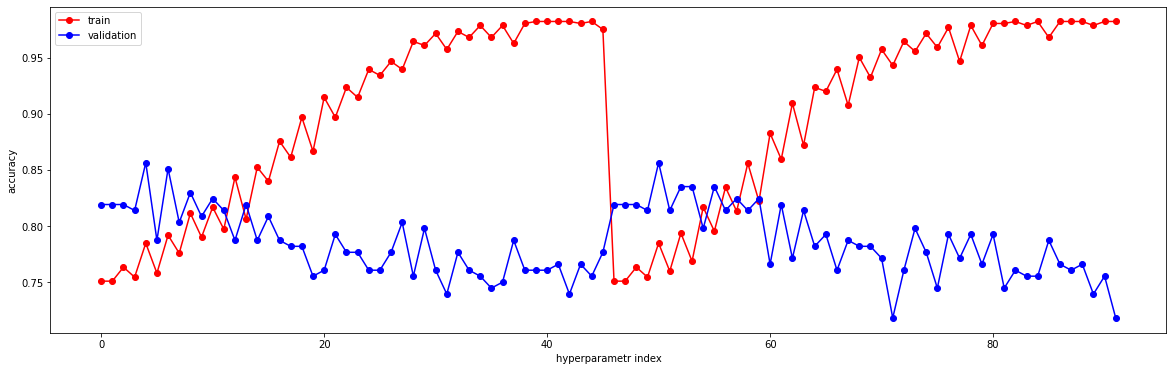

In [20]:
# graficka podoba trenovaci a validacni presnosti v prubehu ladeni
plt.figure(figsize=(20,6))
plt.plot(train_acc, 'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [21]:
#informace o nejlepsi a presnosti validacni a trenovaci mnoziny dat, nejlepsi kombinace
dt_best_params = param_comb[np.argmax(val_acc)]
print(dt_best_params)
print(val_acc[np.argmax(val_acc)])
print(train_acc[np.argmax(val_acc)])

{'splitter': 'best', 'max_depth': 3, 'criterion': 'entropy'}
0.8563829787234043
0.7846975088967971


In [22]:
#testovani modelu na nejlepsi kombinaci
dt = DecisionTreeClassifier(**dt_best_params)
dt.fit(xtrain, ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [23]:
#informace o presnosti vysledneho modelu na trenovaci, validacni a testovaci mnozine
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, dt.predict(xval))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(xtest))))

accuracy score (train): 0.784698
accuracy score (validation): 0.856383
accuracy score (test): 0.816000


* Druhým modelem, který na těchto datech chci použít je Random Forest
* Vybírám parametry k ladění a pomocí nich hledám nejlepší kombinaci
* Společně s laděním si zjišťuji i nejlepší kombinaci pomocí křížové validace

In [24]:
#random forest
param_grid = {
    'n_estimators': range(1, 100, 5),
    'max_depth': range(1, 5)
}
param_comb = ParameterGrid(param_grid)

val_acc = []
train_acc = []
#prohledavani kombinaci k ziskani te nejlepsi k natrenovani modelu
for params in param_comb:
    rf = RandomForestClassifier(**params)
    rf = rf.fit(xtrain, ytrain.values.ravel())
    train_acc.append(metrics.accuracy_score(ytrain, rf.predict(xtrain)))
    val_acc.append(metrics.accuracy_score(yval, rf.predict(xval)))
    
#křížová validace - její nalezené nejlepší kombinace
rf_cross_params = get_best_params('rf', param_comb, 'survived', dtdata)

Best params: {'n_estimators': 46, 'max_depth': 4}
Best RMSLE:  0.444182687228836


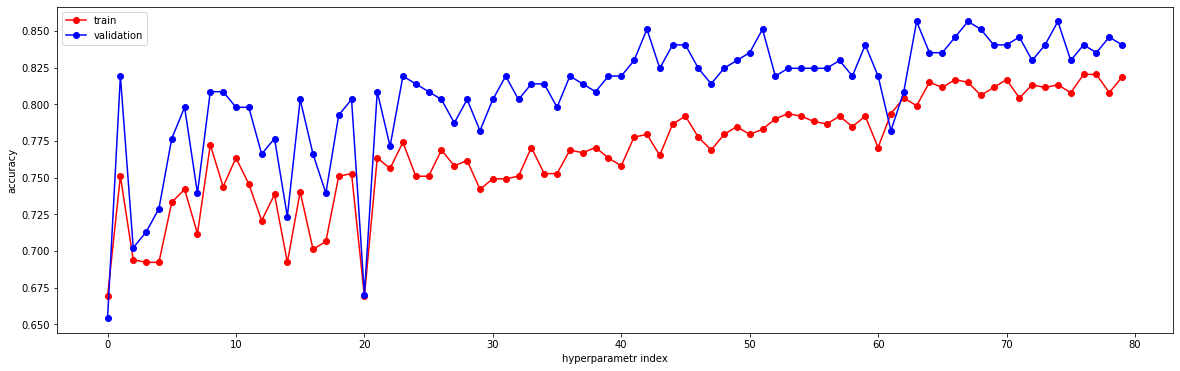

In [25]:
# graficka reprezentace postupneho ladeni modelu
plt.figure(figsize=(20,6))
plt.plot(train_acc, 'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [26]:
# vypsani nejlepsi nalezene kombinace
rf_best_params = param_comb[np.argmax(val_acc)]
print(rf_best_params)
print(val_acc[np.argmax(val_acc)])
print(train_acc[np.argmax(val_acc)])

{'n_estimators': 16, 'max_depth': 4}
0.8563829787234043
0.798932384341637


In [27]:
#pouziti nejlepsi kombinace hyper-parametru
rf = RandomForestClassifier(**rf_best_params)
rf.fit(xtrain, ytrain.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=16,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
#vypsani presnosti na trenovaci, validacni a testovaci mnozine dat
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, rf.predict(xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, rf.predict(xval))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, rf.predict(xtest))))

accuracy score (train): 0.820285
accuracy score (validation): 0.840426
accuracy score (test): 0.816000


### Testování výsledků, predikce dat a jejich uležení
* Nyní mám už vše co potřebuji k predikci dat bez vysvětlované hodnoty
* Než se však na to pustím, je třeba tyto data opět upravit, vyčistit a připravit pro natrénované modely

In [29]:
#nacteni dat
eval_data = pd.read_csv("evaluation.csv")

#uchovani originalnich dat
org_data = eval_data

#nahlednuti do dat, ktera chybi a ktera ne
eval_data = eval_data.replace('?', np.nan)
print(eval_data.isnull().sum(axis=0))

#nahrazeni chybejicich hodnot znakem ?, lepe se mi s tim pak pracuje
eval_data = eval_data.fillna('?')
#info o jednom zaznamu, abych ho mohl dale doplnit nalezitou hodnotou fare
display(eval_data[eval_data.fare == '?'])

ID             0
pclass         0
name           0
sex            0
age           60
sibsp          0
parch          0
ticket         0
fare           1
cabin        240
embarked       0
home.dest    118
dtype: int64


,ID,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
149,1149,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,?,?,S,?


In [30]:
#predzpracovani dat
#redukce a nahrazeni chybejicich hodnot
eval_data = eval_data[["pclass", "sex", "age", "sibsp", "parch", "embarked", "fare", 'home.dest', 'cabin']]
eval_data = eval_data.fillna('?')

#embarked preprocessing na zaklade podobnych zaznamu
simel = eval_data.loc[(eval_data.sex=="male") & (eval_data.pclass==3) & (eval_data.fare!='?') & (eval_data.sibsp==0) & (eval_data.parch ==0)]
mostCom = simel.fare.mode().to_list()[0]

eval_data.loc[(eval_data.fare=='?'), 'fare'] = mostCom
eval_data = eval_data.astype({'fare': 'int64'})

#home.dest preprocessing
eval_data['home.dest'] = np.select([(eval_data['home.dest']=='?'),(True)], [0, 1])

#cabin
eval_data.cabin = np.select([(eval_data.cabin == '?'), (True)], [0, 1])

#retype age column
eval_data = eval_data.astype({"home.dest": "int64"})

eval_data.loc[(eval_data.sex == 'male'), 'sex']   = 1
eval_data.loc[(eval_data.sex == 'female'), 'sex'] = 0

eval_data = eval_data.astype({'sex': 'int64'})

#embarked
eval_data.embarked.unique()
eval_data.embarked = eval_data.embarked.astype('category')
eval_data["embarked"] = eval_data.embarked.cat.codes

In [31]:
display(eval_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pclass     309 non-null    int64 
 1   sex        309 non-null    int64 
 2   age        309 non-null    object
 3   sibsp      309 non-null    int64 
 4   parch      309 non-null    int64 
 5   embarked   309 non-null    int8  
 6   fare       309 non-null    int64 
 7   home.dest  309 non-null    int64 
 8   cabin      309 non-null    int64 
dtypes: int64(7), int8(1), object(1)
memory usage: 19.7+ KB


None

In [32]:
#age preprocessing
#eval_data = median_age_missing_finder(eval_data)
eval_data = knn_missing_values_finder(eval_data[eval_data.age!='?'], 'age', eval_data[eval_data.age=='?'].drop(columns='age'))

eval_data = eval_data.astype({"age": "float"})

In [33]:
#cross-validation, porovnani predikce jednotlivych modelu
display(dt.predict(eval_data))
display(rf.predict(eval_data))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,

* Uložení dat s jejich predikcí survived
* Pro predikci survived hodnoty používám model Random Forest
    * Z několika běhů programu jsem vypozoroval, že má daleko stabilnější a lepší výsledky oproti Decision Tree
    * Na základě toho jej využívám ke generování predikce

In [34]:
#vyber modelu ktery pouziji
model = rf
#predikce
pre_sur = model.predict(eval_data)
#vlozeni predikce k datum
org_data['survived'] = pre_sur
#vybrani jen chtenych dat
result = org_data[['ID', 'survived']]
#ulozeni do souboru
result.to_csv('result.csv', sep=',', index=False)

* Nakonec ověřuji kvalitu vybraného modelu pomocí křížové validace

In [35]:
#crossvalidation
data = dtdata
n_splits = 5
random_seed = 12247112
comb_err = []

for train, val in KFold(n_splits=n_splits, random_state=random_seed).split(data.index):
    #vytvoreni trenovaci a validacni mnoziny
    xtrain = data[data.index.isin(train)].drop(columns='survived')
    ytrain = data[data.index.isin(train)]['survived']
    xval = data[data.index.isin(val)].drop(columns='survived')
    yval = data[data.index.isin(val)]['survived']

    # Scaler opět nafitujeme podle trénovacích dat a následně transformujeme i validační
    scaler = MinMaxScaler()
    xtrain = pd.DataFrame(scaler.fit_transform(xtrain), index=xtrain.index, columns=xtrain.columns)
    xval = pd.DataFrame(scaler.transform(xval), index=xval.index, columns=xval.columns)

    # Natrénujeme model a změříme validační chybu (RMSLE)
    model = RandomForestClassifier(**rf_cross_params)
    #model = DecisionTreeClassifier(**dt_best_params)
    model = model.fit(xtrain, ytrain.values.ravel())
    comb_err.append(np.sqrt(metrics.mean_squared_error(yval, model.predict(xval))))
    

In [36]:
#zobrazeni kvality modelu pomoci stredni hodnoty ze vsech hodnot v comb_err
print('Mean error:', np.mean(comb_err))

Mean error: 0.45886208975424825
